# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split, StratifiedKFold

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import time
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [2]:
def open_and_analyse(path):
    df = pd.read_csv(path)
    print("-----INFO-----\n")
    display(df.info())
    print("\n-----ПЕРВЫЕ 3 СТРОКИ-----")
    display(df.head(3))
    print("\n-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----\n")
    display(df.nunique())
    print("\n-----describe-----")
    
    def describe(df):
        #Возвращает транспонированный describe()
        #Добавляет строку с долей пропусков для каждого столбца
        def na_part(data):
            #Агрегирует долю пропусков в объектах pandas
            part = data.isna().sum() / len(data) * 100
            return part
        return df.describe().append(df.agg([na_part])).transpose()

    display(describe(df))
    print("\n-----КОРРЕЛЯЦИЯ-----")
    display(df.corr())
    return df

In [3]:
df = open_and_analyse("/datasets/autos.csv")

-----INFO-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: i

None


-----ПЕРВЫЕ 3 СТРОКИ-----


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46



-----УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----



DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64


-----describe-----


,count,mean,std,min,25%,50%,75%,max,na_part
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0,0.000000
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0,0.000000
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0,0.000000
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0,0.000000
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0,0.000000
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0,0.000000
DateCrawled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
VehicleType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.579368
Gearbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.596709



-----КОРРЕЛЯЦИЯ-----


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


- [X]  Названия столбцов стоит изменить, чтобы нам было проще к ним обращаться. <a id='list'></a>
- [X]  Фотографий везде 0 - удаляем столбец.
- [X]  DateCrawled (дата скачивания анкеты из базы) и LastSeen (дата последней активности пользователя) - не имеют особого смысла для машины, которую мы оцениваем сейчас. Удаляем эти столбец. 
    - [X]  Оставляем только дату размещения объявления: по ней мы можем выявить зависимость цены от времени размещения.
        - [X]  Проверим как сильно влияют на цены месяц и год размещения.
            - [X]  13 месяцев - один лишний. Заменим на медианное значение.
            - [X]  151 вариант года регистрации. Изучим.  
- [X]  petrol и gasoline - названия одного и того же топлива. Заменим gasoline на petrol
- [x]  В данных о ремонте должно быть всего 2 значения: 'yes' и 'no'. NaN скорее означает отсутствие записей о ремонте. Заменим пропуски на 'yes'.
- [X]  Данные содержат пропуски и нули
- [x]  Видим выбросы - нулевые значения мощности и стоимости. Подумаем, что с ними сделать.
- [x]  Нет  сильной корреляции между целевым признаком и другими признаками. Единственное явное - это отрицательная корреляция стоимости и пробега. Что вполне можно объяснить. Если избавить данные от выбросов, к корреляции можно будет вернуться, потому что сейчас эти расчёты далеки от реальности.
- [x]  Данные имеют тип object - категории имеет смысл закодировать.

In [4]:
shape = df.shape[0]

In [5]:
# приведём все названия столбцов в нижний регистр
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
# выбросим лишние столбцы
df.drop(['datecrawled', 'numberofpictures', 'lastseen'], axis=1, inplace=True)
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired',
       'datecreated', 'postalcode'],
      dtype='object')

In [7]:
# приведём названия в порядок
_ = ['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'postal_code']
df.columns = _
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480


In [8]:
df.duplicated().sum() / df.shape[0]

0.02876662462009939

Около 3% дубликатов, которые появились день в день с одним и тем же почтовым индексом. Выглядит так, будто объявление ошибочно создали, удалили и затем создали снова. Удалим их.

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Посмотрим распределения года и месяца регистрации <a id='reg_hist'></a>

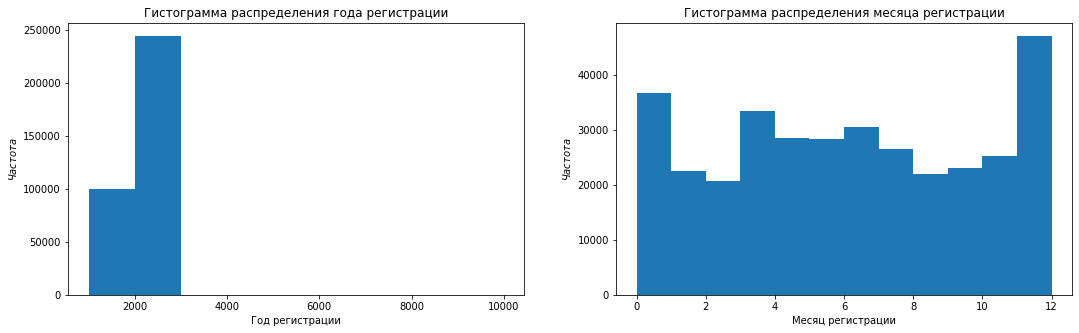

In [10]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(df.registration_year, bins = 9)
ax1.set_title('Гистограмма распределения года регистрации')
ax1.set_xlabel('Год регистрации')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.registration_month, bins=12)
ax2.set_title('Гистограмма распределения месяца регистрации')
ax2.set_xlabel('Месяц регистрации')
ax2.set_ylabel('$Частота$')

plt.show()

In [11]:
df.date_created.max()

'2016-04-07 00:00:00'

In [12]:
print(f'Количество аномальных значений с месяцем регистрации равному 0 - {df.registration_month[df.registration_month == 0].count()}\nЧто составляет {df.registration_month[df.registration_month == 0].count() / df.shape[0]:.0%} от всех данных.')

Количество аномальных значений с месяцем регистрации равному 0 - 36720
Что составляет 11% от всех данных.


Месяц регистрации может влиять на цену. Аномальное значения `0` достоверно заменить не можем. Возможно, кто-то не заполнил параметр и туда прописали 0. Удалять 11% выборки из-за незаполненности сомнительного признака не стоит. 
Учитывая, что данных после 2016г быть не должно и достоверно заменить их не можем - просто отсечём их.  
К томуже, вряд ли кто-то выставляет свой автомобиль зарегистрированный ранее 1945г на продажу - эти данные тоже удалим.

In [13]:
df = df[(df.registration_year <= 2016) & (1945 <= df.registration_year)]

In [14]:
sns.set_style("darkgrid") 

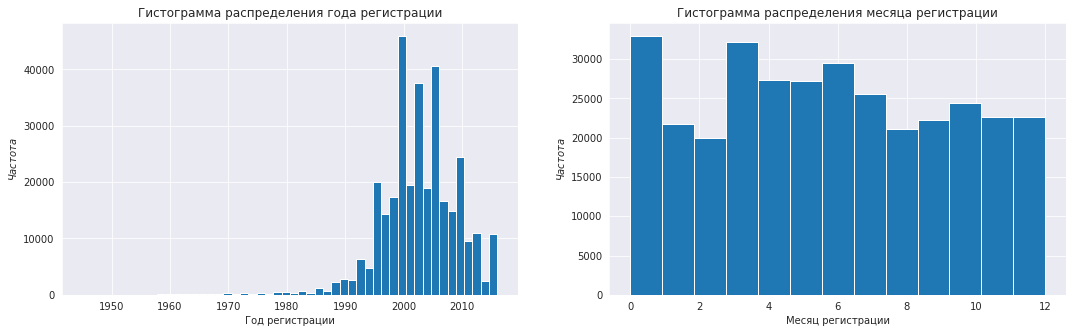

In [15]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(df.registration_year, bins = 50)
ax1.set_title('Гистограмма распределения года регистрации')
ax1.set_xlabel('Год регистрации')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.registration_month, bins=13)
ax2.set_title('Гистограмма распределения месяца регистрации')
ax2.set_xlabel('Месяц регистрации')
ax2.set_ylabel('$Частота$')

plt.show()

Посмторим на график распределения года регистрации поближе.

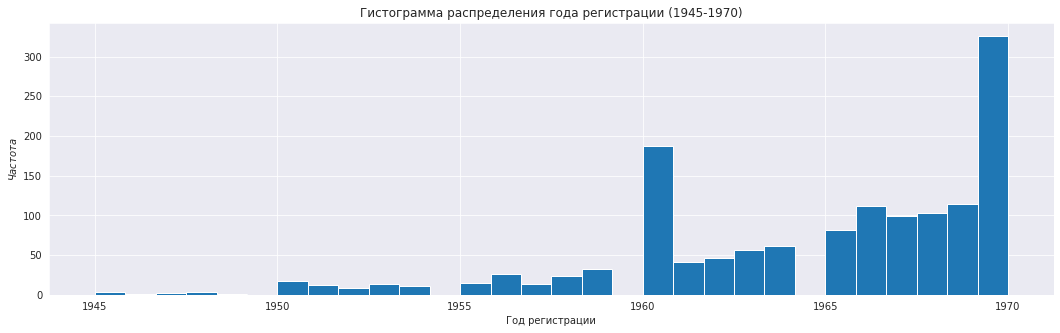

In [16]:
fig, (ax1) = plt.subplots(
    nrows=1, ncols=1,
    figsize=(18, 5)
)
 
ax1.hist(df.registration_year, bins = 30, range=(1945, 1970))
ax1.set_title('Гистограмма распределения года регистрации (1945-1970)')
ax1.set_xlabel('Год регистрации')
ax1.set_ylabel('$Частота$')

plt.show()

Судя по гистограмме, можно и данные об авто, зарегистрированных до 1950г можно также смело удалить.

In [17]:
df = df[(df.registration_year >= 1950)]

Посмотрим распределения мощьночти и почтового индекса <a id='hp_ind'></a>

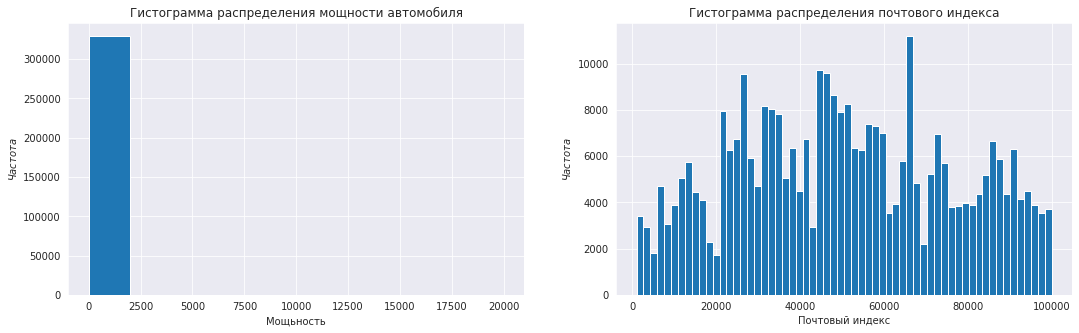

In [18]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(df.power, bins=10)
ax1.set_title('Гистограмма распределения мощности автомобиля')
ax1.set_xlabel('Мощьность')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.postal_code, bins=60)
ax2.set_title('Гистограмма распределения почтового индекса')
ax2.set_xlabel('Почтовый индекс')
ax2.set_ylabel('$Частота$')

plt.show()

В плане мощности:

Чемпионом считается американский карьерный самосвал Caterpillar 797F мощностью 4000 лошадиных сил. Следовательно мощьности свыше 4000 - смело удаляем.  
Peel P50 оборудован 49-кубовым мотоциклетным двигателем мощностью 4,2 лошадиные силы. Значит мощности менее 4лс - удаляем.

In [19]:
df = df[(df.power <= 4000) & (4 <= df.power)]

Рассмотрим гистограмму распределения мощности поближе.

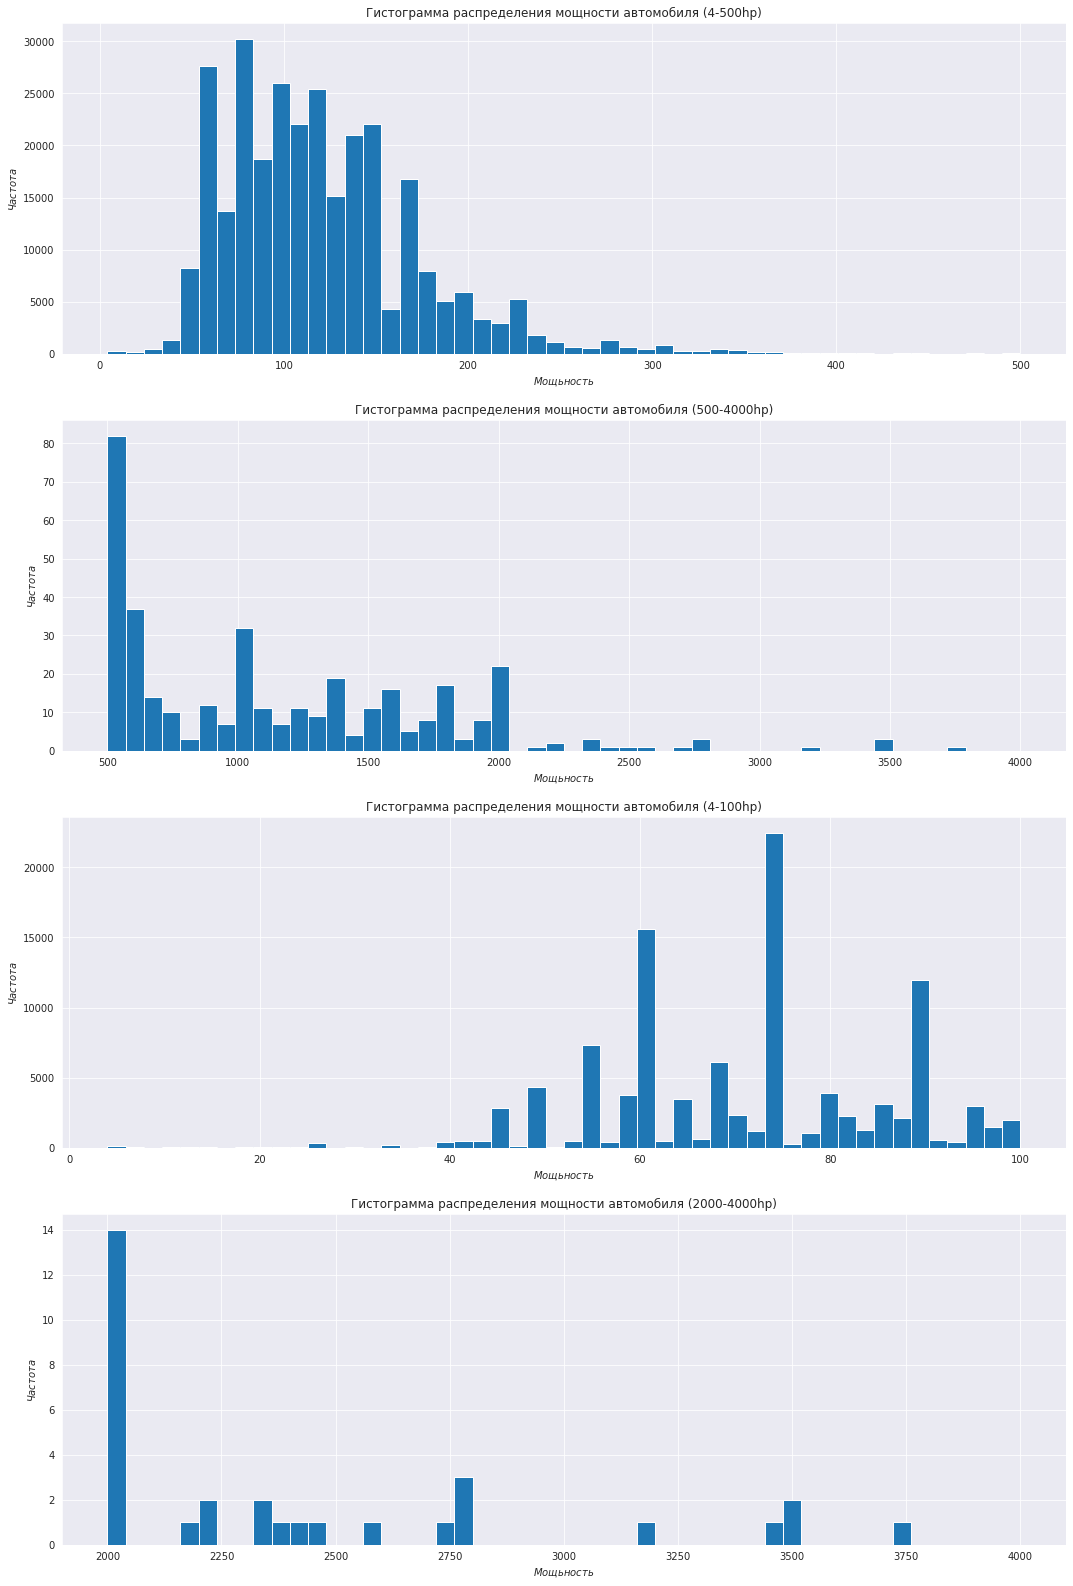

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4, ncols=1,
    figsize=(18, 28)
)
 
ax1.hist(df.power, bins=50, range=(4, 500))
ax1.set_title('Гистограмма распределения мощности автомобиля (4-500hp)')
ax1.set_xlabel('$Мощьность$')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.power, bins=50, range=(500, 4000))
ax2.set_title('Гистограмма распределения мощности автомобиля (500-4000hp)')
ax2.set_xlabel('$Мощьность$')
ax2.set_ylabel('$Частота$')
 
ax3.hist(df.power, bins=50, range=(4, 100))
ax3.set_title('Гистограмма распределения мощности автомобиля (4-100hp)')
ax3.set_xlabel('$Мощьность$')
ax3.set_ylabel('$Частота$')
 
ax4.hist(df.power, bins=50, range=(2000, 4000))
ax4.set_title('Гистограмма распределения мощности автомобиля (2000-4000hp)')
ax4.set_xlabel('$Мощьность$')
ax4.set_ylabel('$Частота$')

plt.show()

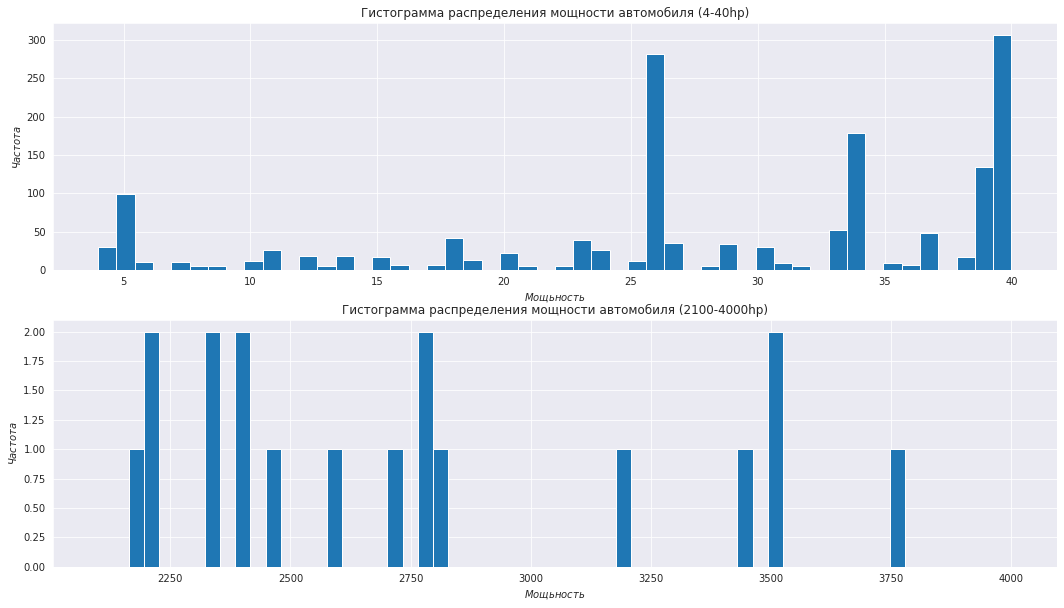

In [21]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(18, 10)
)
 
ax1.hist(df.power, bins=50, range=(4, 40))
ax1.set_title('Гистограмма распределения мощности автомобиля (4-40hp)')
ax1.set_xlabel('$Мощьность$')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.power, bins=60, range=(2100, 4000))
ax2.set_title('Гистограмма распределения мощности автомобиля (2100-4000hp)')
ax2.set_xlabel('$Мощьность$')
ax2.set_ylabel('$Частота$')

plt.show()

- Автомобилей мощьностьб более 2000лс всего по одной две штуки. Они выбиваются из общей закономерности и их стоит удалить для более качественного обучения модели.
- Автомобилей мощностью менее 40лс также очень мало относительно общего распределения. Удалим эти данные.

In [22]:
df = df[(df.power <= 2000) & (40 <= df.power)]

In [23]:
df[['power', 'registration_year', 'registration_month']].nunique()

power                 560
registration_year      67
registration_month     13
dtype: int64

Теперь выглядит гораздо правдоподобней.

In [24]:
df.registration_year.sort_values().unique()

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [25]:
df.registration_month.sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
df.date_created = pd.to_datetime(df.date_created, yearfirst=True).dt.round('D')
df.date_created.sample()

25258   2016-03-06
Name: date_created, dtype: datetime64[ns]

In [27]:
# создадим столбцы с годом, месяцем и днём публикации
df.loc[:, 'year_pub'] = df.date_created.dt.year
df.loc[:, 'month_pub'] = df.date_created.dt.month
df.loc[:, 'day_pub'] = df.date_created.dt.day
display(df[['year_pub', 'month_pub', 'day_pub']].sample(3))

,year_pub,month_pub,day_pub
203148,2016,3,10
88340,2016,3,12
109179,2016,3,11


In [28]:
# удаляем столбец date_created, он нам больше не нужен
df.drop(['date_created'], axis=1, inplace=True)

In [29]:
df.day_pub.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [30]:
df.month_pub.sort_values().unique()

array([ 1,  2,  3,  4,  8,  9, 11, 12])

Как видим - в мае, июле и октябре объявления почему-то не публиковались.

In [31]:
df.year_pub.sort_values().unique()

array([2015, 2016])

In [32]:
df.year_pub.value_counts()

2016    292509
2015        20
Name: year_pub, dtype: int64

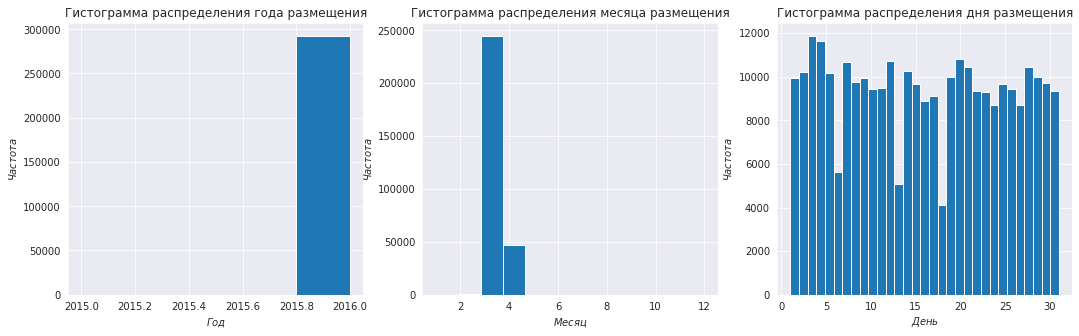

In [33]:
# проверим как сильно влияет на цены время размещения
year_stat = df.groupby('year_pub').agg({'price': 'mean'})
month_stat = df.groupby('month_pub').agg({'price': 'mean'})
day_stat = df.groupby('day_pub').agg({'price': 'mean'})

 
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3,
    figsize=(18, 5)
)
 
ax1.hist(df.year_pub, bins=5)
ax1.set_title('Гистограмма распределения года размещения')
ax1.set_xlabel('$Год$')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.month_pub, bins=12)
ax2.set_title('Гистограмма распределения месяца размещения')
ax2.set_xlabel('$Месяц$')
ax2.set_ylabel('$Частота$')
 
ax3.hist(df.day_pub, bins=31)
ax3.set_title('Гистограмма распределения дня размещения')
ax3.set_xlabel('$День$')
ax3.set_ylabel('$Частота$')
 
plt.show()

$Видим:$

- Практически все обьявления из оставшихся публиковались с конца 2015г по 2016г. Причём, в основном, в марте-апреле. В расчёт эти данные брать нельзя.
- С днями ситуация выглядит правдоподобно.

Посмотрим на взаимосвязь проанализированных признаков с ценой <a id='price_1'></a>

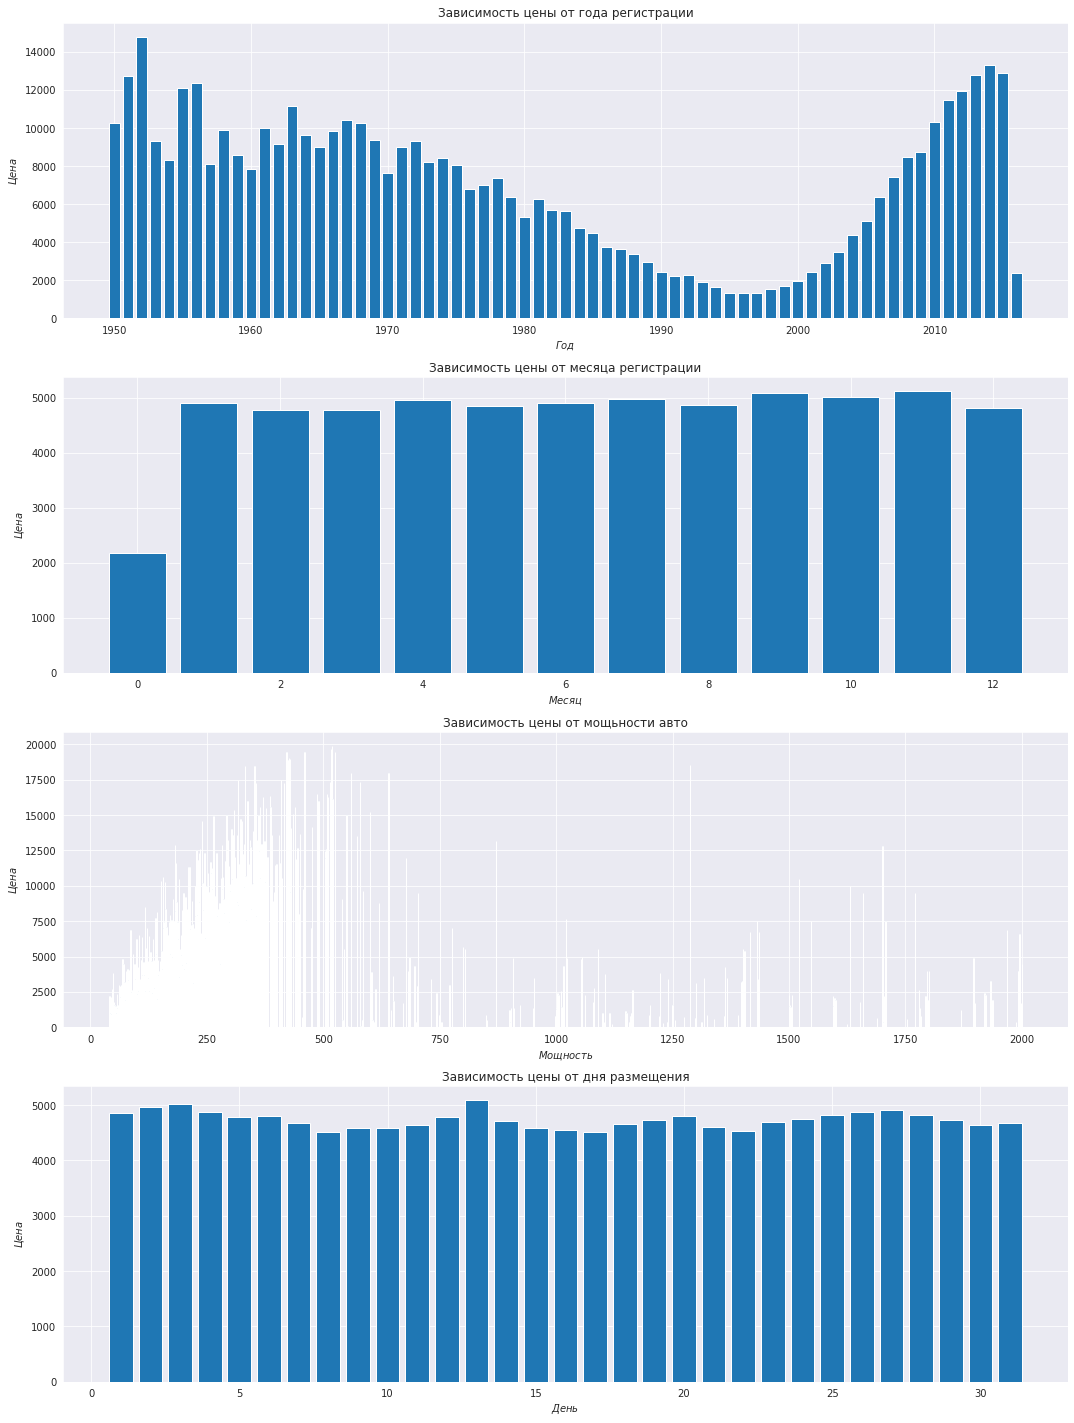

In [34]:
# проверим как сильно влияет на цены время размещения
year_stat = df.groupby('registration_year').agg({'price': 'mean'})
month_stat = df.groupby('registration_month').agg({'price': 'mean'})
hp_stat = df.groupby('power').agg({'price': 'mean'})
day_stat = df.groupby('day_pub').agg({'price': 'mean'})

 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4, ncols=1,
    figsize=(18, 25)
)
 
ax1.bar(year_stat.index, year_stat.price)
ax1.set_title('Зависимость цены от года регистрации')
ax1.set_xlabel('$Год$')
ax1.set_ylabel('$Цена$')
 
ax2.bar(month_stat.index, month_stat.price)
ax2.set_title('Зависимость цены от месяца регистрации')
ax2.set_xlabel('$Месяц$')
ax2.set_ylabel('$Цена$')
 
ax3.bar(hp_stat.index, hp_stat.price)
ax3.set_title('Зависимость цены от мощьности авто')
ax3.set_xlabel('$Мощность$')
ax3.set_ylabel('$Цена$')
 
ax4.bar(day_stat.index, day_stat.price)
ax4.set_title('Зависимость цены от дня размещения')
ax4.set_xlabel('$День$')
ax4.set_ylabel('$Цена$')
 
plt.show()

Зависимости по всем 4 признакм есть. Хоть зависимость средней цены от месяца регистрации незначительная, но цена отдельного автомобиля варируется от месяца к месяцу.

In [35]:
# удаляем столбец с месяцем и годом публикации
df.drop(['month_pub', 'year_pub'], axis=1, inplace=True)

# также удаляем ненужные больше переменные
del (year_stat, month_stat, day_stat)

df.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,day_pub
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,14


<div class="alert alert-warning">
<h4> ~2~ ⚠️</h4> 

day_pub тоже можно было удалять . 
    
</div>

In [36]:
df.fuel_type.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [37]:
df.fuel_type.value_counts()

petrol      184849
gasoline     85888
lpg           4615
cng            479
hybrid         197
other           56
electric        39
Name: fuel_type, dtype: int64

`petrol` и `gasoline` - это названия бензина на американском и на британском. Они могут говорить о месте производства автомобиля — завод в США или в Европе.

In [38]:
# заменим  nan на 'unknown'
df.fuel_type = df.fuel_type.fillna('unknown')
df.fuel_type.unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [39]:
df.not_repaired.unique()

array(['yes', nan, 'no'], dtype=object)

In [40]:
df.not_repaired.value_counts()

no     218611
yes     29601
Name: not_repaired, dtype: int64

Соотношение неремонтируемых машин к ремонтируемым всего 13%. Доля пропусков в этом столбце около 20%. Мы не можем точно сказать, являются ли пропуски фактом отсутствия ремонта или же наоборот - намеренным умалчиванием о ремонте, поэтому заменим их на `unknown`

In [41]:
# заменим значения yes на 1, а no на 0 и заменим пропуски на 1
df.not_repaired = df.not_repaired.fillna('unknown')
df.not_repaired.unique()

array(['yes', 'unknown', 'no'], dtype=object)

Посмотрим, где и сколько пропусков осталось.

In [42]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(f'''Доля пропусков в столбце "{df[i].name}" равна {df[i].isna().sum() / len(df[i]):.1%} и составляет {
df[i].isna().sum()} пропусков''')

Доля пропусков в столбце "vehicle_type" равна 4.0% и составляет 11788 пропусков
Доля пропусков в столбце "gearbox" равна 1.9% и составляет 5578 пропусков
Доля пропусков в столбце "model" равна 3.9% и составляет 11549 пропусков


Пройдёмся по каждому признаку. Посмотрим, насколько он важен, и можно ли его заполнить.

При очистке данных от пропусков стоит выбор между полным удалением объектов с пропусками(мы не можем на основе других параметров объекта достоверно восстановить упущенную информацию). Удаление объектов с пропусками привело бы к потере около 8% данных, что критично. Замеим пропуски на `unknown`.

In [43]:
# посмотрим какие есть типы кузова
df.vehicle_type.unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [44]:
# посмотрим какие есть типы коробки передач
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [45]:
# заменяем пропуски на unknown
df.vehicle_type = df.vehicle_type.fillna('unknown')
df.gearbox = df.gearbox.fillna('unknown')
df.model = df.model.fillna('unknown')
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
postal_code           0
day_pub               0
dtype: int64

In [46]:
print(f'Выбросов (нулевых значений) в столбце цены - {df.price[df.price == 0].count()}, что состаавляет {df.price[df.price == 0].count() / len(df):.1%}\nУдалим их.')

Выбросов (нулевых значений) в столбце цены - 6171, что состаавляет 2.1%
Удалим их.


In [47]:
df = df[df.price > 0]

<AxesSubplot:>

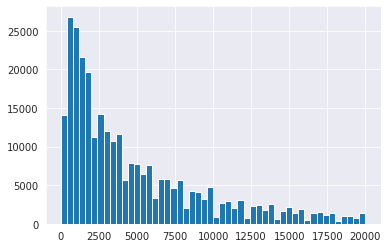

In [48]:
df.price.hist(bins=50)

500 евро - это около 34 тыс. руб. - цена нашего видавшего вида жигули :)  
Вряд ли за рубежом есть цены ниже этой.  
Требуется провести исследование по факту высокой доли нулей в целевой переменной.

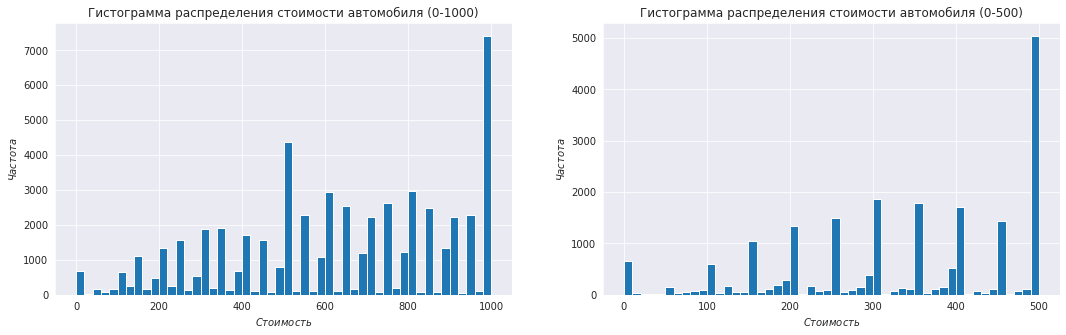

In [49]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, 5)
)
 
ax1.hist(df.price, bins=50, range=(0, 1000))
ax1.set_title('Гистограмма распределения стоимости автомобиля (0-1000)')
ax1.set_xlabel('$Стоимость$')
ax1.set_ylabel('$Частота$')
 
ax2.hist(df.price, bins=50, range=(0, 500))
ax2.set_title('Гистограмма распределения стоимости автомобиля (0-500)')
ax2.set_xlabel('$Стоимость$')
ax2.set_ylabel('$Частота$')

plt.show()

In [50]:
print(f'''Шаг цены, в основном, 100евро. 
Авто с шагом в 50 ервро в разы меньше. 
Количество продаваемых авто по цене менее 500евро - {df.price[df.price < 500].count()}, что составляет {df.price[df.price < 500].count() / df.shape[0]:.0%} от всех данных.\nУдалим их.''')

Шаг цены, в основном, 100евро. 
Авто с шагом в 50 ервро в разы меньше. 
Количество продаваемых авто по цене менее 500евро - 16700, что составляет 6% от всех данных.
Удалим их.


In [51]:
df = df[df.price >= 500].dropna()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269658 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               269658 non-null  int64 
 1   vehicle_type        269658 non-null  object
 2   registration_year   269658 non-null  int64 
 3   gearbox             269658 non-null  object
 4   power               269658 non-null  int64 
 5   model               269658 non-null  object
 6   kilometer           269658 non-null  int64 
 7   registration_month  269658 non-null  int64 
 8   fuel_type           269658 non-null  object
 9   brand               269658 non-null  object
 10  not_repaired        269658 non-null  object
 11  postal_code         269658 non-null  int64 
 12  day_pub             269658 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 28.8+ MB


In [53]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'postal_code', 'day_pub'],
      dtype='object')

In [54]:
df = df[['price', 'brand', 'model', 'gearbox', 'fuel_type', 'vehicle_type', 'registration_month', 'registration_year','power',
         'kilometer', 'not_repaired', 'postal_code', 'day_pub']]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269658 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               269658 non-null  int64 
 1   brand               269658 non-null  object
 2   model               269658 non-null  object
 3   gearbox             269658 non-null  object
 4   fuel_type           269658 non-null  object
 5   vehicle_type        269658 non-null  object
 6   registration_month  269658 non-null  int64 
 7   registration_year   269658 non-null  int64 
 8   power               269658 non-null  int64 
 9   kilometer           269658 non-null  int64 
 10  not_repaired        269658 non-null  object
 11  postal_code         269658 non-null  int64 
 12  day_pub             269658 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 28.8+ MB


In [56]:
# уменьшим обращение данных к памяти
#numeric_columns = ['price', 'registration_month', 'registration_year', 'power', 'kilometer', 'postal_code', 'day_pub']
#for col in df[numeric_columns]:
#    df[col] = pd.to_numeric(df[col], downcast='unsigned')
    
#display(df.info())

In [57]:
#print(f'Уменьшение использования памяти на {1 - 15.3 / 23.9:.2%}')
#df.head()

In [58]:
print(f'''
Мы удалили незначимые столбцы.
Проверим дубликаты заново, ведь одно и тоже обьявление могло подаваться несколько раз с разных аккаунтов.
Количетво дубликатов: {df.duplicated().sum()}
Что составляет {df.duplicated().sum() / df.shape[0]:.1%}
''')


Мы удалили незначимые столбцы.
Проверим дубликаты заново, ведь одно и тоже обьявление могло подаваться несколько раз с разных аккаунтов.
Количетво дубликатов: 2
Что составляет 0.0%



In [59]:
df.drop_duplicates(inplace=True)

In [60]:
df.duplicated().sum()

0

In [61]:
display(df.sample(3))
df.info()

,price,brand,model,gearbox,fuel_type,vehicle_type,registration_month,registration_year,power,kilometer,not_repaired,postal_code,day_pub
233781,1599,chrysler,grand,auto,petrol,bus,7,1998,182,150000,no,84405,21
37003,4000,toyota,yaris,manual,petrol,small,6,2004,105,100000,no,97772,29
326550,1100,bmw,3er,manual,petrol,coupe,2,1994,150,150000,no,72764,29


<class 'pandas.core.frame.DataFrame'>
Int64Index: 269656 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               269656 non-null  int64 
 1   brand               269656 non-null  object
 2   model               269656 non-null  object
 3   gearbox             269656 non-null  object
 4   fuel_type           269656 non-null  object
 5   vehicle_type        269656 non-null  object
 6   registration_month  269656 non-null  int64 
 7   registration_year   269656 non-null  int64 
 8   power               269656 non-null  int64 
 9   kilometer           269656 non-null  int64 
 10  not_repaired        269656 non-null  object
 11  postal_code         269656 non-null  int64 
 12  day_pub             269656 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 28.8+ MB


In [62]:
print(f'''
Уменьшили размер таблицы на {shape - df.shape[0]} строк ({1 - df.shape[0] / shape:.1%})
Уменьшили использования памяти на {1 - 15.3 / 43.3:.1%}''')

# удалим временные перемнные
del (shape)


Уменьшили размер таблицы на 84713 строк (23.9%)
Уменьшили использования памяти на 64.7%


**Вывод**

1. Изменили названия столбцов в соответствии с правилами оформления.
2. Создали столбец	`day_pub` из столбца `date_created`, а его удалили. Удалили столбцы `datecrawled`, `numberofpictures`, `lastseen` за ненадобностью.
3. Удалили около 7% дубликатов.
4. Удалили выбросы из столбцов мощьности и года регистрации.
5. Пропуски в `brand`, `model`, `gearbox`, `fuel_type`, `vehicle_type` и `not_repaired` заменили на `unknown`, так как не было возможности достоверно восстановить данные.
6. Нулевые  и неадекватно низкие значения стоимости удалили.

## Кодирование признаков

Сейчас почти все категориальные признаки имеют строковый тип. Это читаемо для исследовательского анализа, но не очень подходит для машинного обучения.

Учитывая, что в catboost есть встроенное кодирование, и, зачастую, оно позволяет достичь лучших результатов, то сделаем 3 выборки:
1. Сохраним категориальные переменные, как есть для catboost и lgbm.
```python
catboost_data = df.copy
```
2. Закодируем всё с помощью OHE.
```python
OHE_data = df.copy
```
3. Закодируем всё с помощью OrdinalEncoder.
```python
OE_data = df.copy
```
В итоге проверим модель на всех выборках и поймём, где лучше.

In [63]:
catboost_data = df.copy()
OHE_data = df.copy()
OE_data = df.copy()

In [64]:
# столбцы с категориями
cat_columns = ['brand', 'model', 'gearbox', 'fuel_type', 'vehicle_type', 'not_repaired', 'postal_code']
catboost_data[cat_columns] = catboost_data[cat_columns].astype('category')
catboost_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269656 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               269656 non-null  int64   
 1   brand               269656 non-null  category
 2   model               269656 non-null  category
 3   gearbox             269656 non-null  category
 4   fuel_type           269656 non-null  category
 5   vehicle_type        269656 non-null  category
 6   registration_month  269656 non-null  int64   
 7   registration_year   269656 non-null  int64   
 8   power               269656 non-null  int64   
 9   kilometer           269656 non-null  int64   
 10  not_repaired        269656 non-null  category
 11  postal_code         269656 non-null  category
 12  day_pub             269656 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 17.0 MB


### OHE_data

In [65]:
OHE_data = pd.get_dummies(OHE_data, drop_first=True)

In [66]:
OHE_data.head(3)

,price,registration_month,registration_year,power,kilometer,postal_code,day_pub,brand_audi,brand_bmw,brand_chevrolet,...,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,not_repaired_unknown,not_repaired_yes
1,18300,5,2011,190,125000,66954,24,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,9800,8,2004,163,125000,90480,14,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1500,6,2001,75,150000,91074,17,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [67]:
OHE_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269656 entries, 1 to 354368
Columns: 314 entries, price to not_repaired_yes
dtypes: int64(7), uint8(307)
memory usage: 95.4 MB


### OE_data

In [68]:
OE_data[cat_columns] = OrdinalEncoder().fit_transform(OE_data[cat_columns])

In [69]:
display(OE_data.head(3))
OE_data.info()

,price,brand,model,gearbox,fuel_type,vehicle_type,registration_month,registration_year,power,kilometer,not_repaired,postal_code,day_pub
1,18300,1.0,227.0,1.0,2.0,2.0,5,2011,190,125000,2.0,4589.0,24
2,9800,14.0,117.0,0.0,2.0,6.0,8,2004,163,125000,1.0,6962.0,14
3,1500,38.0,116.0,1.0,6.0,5.0,6,2001,75,150000,0.0,7002.0,17


<class 'pandas.core.frame.DataFrame'>
Int64Index: 269656 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               269656 non-null  int64  
 1   brand               269656 non-null  float64
 2   model               269656 non-null  float64
 3   gearbox             269656 non-null  float64
 4   fuel_type           269656 non-null  float64
 5   vehicle_type        269656 non-null  float64
 6   registration_month  269656 non-null  int64  
 7   registration_year   269656 non-null  int64  
 8   power               269656 non-null  int64  
 9   kilometer           269656 non-null  int64  
 10  not_repaired        269656 non-null  float64
 11  postal_code         269656 non-null  float64
 12  day_pub             269656 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 28.8 MB


## Обучение моделей

Выберем следующие регрессоры для обучения модели:

- LinearRegression  
- Ridge  
- DecisionTreeRegressor  
- Lasso
- RabdomForestRegressor
- CatBoostRegressor
- LGBMRegressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

Подготовим 2 типа признаков для кроссвалидации:

1. Неизмененные: `catboost_data`
2. Закодированные методом OHE: `OHE_data`
3. Закодированные методом OrdinalEncoder: `OE_data`

### Разделение данных на выборки

In [70]:
RANDOM_STATE = 8726

In [71]:
# разделим данные на выборки
train_catboost, test_catboost, train_OHE, test_OHE, train_OE, test_OE = train_test_split(
    catboost_data, OHE_data, OE_data,
    random_state=RANDOM_STATE)

In [72]:
print('Размерность неизмененной train_test выборки')
for a in (train_catboost, test_catboost):
    print(a.shape)
print('\nРазмерность train_test выборки закодированной OHE')
for a in (train_OHE, test_OHE):
    print(a.shape)
print('\nРазмерность train_test выборки закодированной OrdinalEncoder')
for a in (train_OE, test_OE):
    print(a.shape)
    
del a

Размерность неизмененной train_test выборки
(202242, 13)
(67414, 13)

Размерность train_test выборки закодированной OHE
(202242, 314)
(67414, 314)

Размерность train_test выборки закодированной OrdinalEncoder
(202242, 13)
(67414, 13)


Разделение выполнено верно.

In [73]:
# catboost выборка
x_train_catboost = train_catboost.drop('price', axis=1)
y_train_catboost = train_catboost.price

x_test_catboost = test_catboost.drop('price', axis=1)
y_test_catboost = test_catboost.price

# OHE принаки
x_train_OHE = train_OHE.drop('price', axis=1)
y_train_OHE = train_OHE.price

x_test_OHE = test_OHE.drop('price', axis=1)
y_test_OHE = test_OHE.price

# OrdinalEncoder принаки
x_train_OE = train_OE.drop('price', axis=1)
y_train_OE = train_OE.price

x_test_OE = test_OE.drop('price', axis=1)
y_test_OE = test_OE.price

In [74]:
folds = StratifiedKFold(n_splits=5,  shuffle=True, random_state=RANDOM_STATE)

### Линейная регрессия

In [75]:
%%time

start_time = time.time()

regressor = LinearRegression()
print('RMSE на train выборке')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             x_train_OHE, 
                             y_train_OHE, 
                             cv=folds, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

current_time = time.time()
cv_RMSE_LR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_LR}\n')

RMSE на train выборке

RMSE модели на обучающей выборке = 2663.4289540907125

CPU times: user 49.3 s, sys: 21 s, total: 1min 10s
Wall time: 1min 10s


In [76]:
%%time

start_time = time.time()

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('RMSE на train выборке')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                x_train_OHE, 
                                y_train_OHE, 
                                cv=folds, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
                                
current_time = time.time()
cv_RMSE_LR_S_t = current_time-start_time
print(f'RMSE с использовнием StandardScaler = {cv_RMSE_LR_S}\n')

RMSE на train выборке

RMSE с использовнием StandardScaler = 956077041.4476415

CPU times: user 55.1 s, sys: 23.9 s, total: 1min 18s
Wall time: 1min 19s


Масштабирование признаков не сильно повлияло на модель.  
Откажемся от применения масштаба.

---

Проведем обучение модели.

In [77]:
%%time

start_time = time.time()

model = LinearRegression()
model.fit(x_train_OHE, y_train_OHE)

current_time = time.time()
LR_fit_t = current_time-start_time

CPU times: user 12.2 s, sys: 4.14 s, total: 16.4 s
Wall time: 16.4 s


In [78]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_OHE)

current_time = time.time()
LR_predict_t = current_time-start_time

CPU times: user 153 ms, sys: 87.5 ms, total: 241 ms
Wall time: 215 ms


In [79]:
final_RMSE_LR = mean_squared_error(y_test_OHE, target_predict) ** 0.5
final_RMSE_LR

2626.925788276656

### Ridge

In [ ]:
%%time

start_time = time.time()

regressor = Ridge(random_state=RANDOM_STATE)
hyperparams = {'solver': ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg'],
              'alpha': [0.001 , 0.01 , 0.1 , 1 , 10]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams, cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_OHE, y_train_OHE)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_R_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_R}\n')

Подбор параметров для RMSE



---

Проведем обучение на модели с лучшими гиперпараметрами.

In [ ]:
%%time

start_time = time.time()

model = Ridge(alpha=1, 
              solver='svd',
              random_state=RANDOM_STATE)
model.fit(x_train_OHE, y_train_OHE)

current_time = time.time()
R_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_OHE)

current_time = time.time()
R_predict_t = current_time-start_time

In [ ]:
final_RMSE_R = mean_squared_error(y_test_OHE, target_predict) ** 0.5
final_RMSE_R

### DecisionTreeRegressor

In [ ]:
%%time

start_time = time.time()

regressor = DecisionTreeRegressor(criterion='mse' , random_state=RANDOM_STATE) 
hyperparams = {'max_depth': [8 , 10 , 12 , 15 , 20 , 25], 
               'min_samples_leaf': [10 , 20 , 50 , 100 , 200 , 500]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams, cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_OE, y_train_OE)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_DTR_t = current_time-start_time
print(f'RMSE модели на для обучающей выборке = {cv_RMSE_DTR}\n')

---

Проведем обучение на модели с лучшими гиперпараметрами.

In [ ]:
%%time

start_time = time.time()

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=20, 
                              min_samples_leaf=20,
                              random_state=RANDOM_STATE) 
model.fit(x_train_OE, y_train_OE)

current_time = time.time()
DTR_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_OE)

current_time = time.time()
DTR_predict_t = current_time-start_time

In [ ]:
final_RMSE_DTR = mean_squared_error(y_test_OE, target_predict) ** 0.5
final_RMSE_DTR

### Lasso

In [ ]:
%%time
# подбор гиперпраметрах при переборе 'alpha':[0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000 , 10000]
#                                    'max_iter': [500, 600, 700, 900, 1000, 1100]
# Wall time: 3h 20min 42s
# в связи с этим уменьшаю вариативность параметров для повторного подбора
start_time = time.time()

regressor = Lasso(normalize=True, random_state=RANDOM_STATE)
hyperparams = {'alpha':[0.0001 , 0.001 , 0.01],
               'max_iter': [1000, 1100],
               'selection': ['cyclic', 'random']}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_OHE, y_train_OHE)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_L = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_L_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_L}\n')

---

Проведем обучение на модели с лучшими гиперпараметрами.

In [ ]:
%%time

start_time = time.time()

model =Lasso(alpha=0.0001, 
             max_iter=1100,
             selection='cyclic',
             normalize=True,
             random_state=RANDOM_STATE)
model.fit(x_train_OHE, y_train_OHE)

current_time = time.time()
L_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_OHE)

current_time = time.time()
L_predict_t = current_time-start_time

In [ ]:
final_RMSE_L = mean_squared_error(y_test_OHE, target_predict) ** 0.5
final_RMSE_L

### RandomForestRegressor

In [ ]:
%%time

start_time = time.time()

regressor = RandomForestRegressor(criterion='mse', random_state=RANDOM_STATE)
hyperparams = {'n_estimators':[20, 100, 200, 300, 350],
               'max_depth':[8, 10, 12, 20]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_OE.sample(20000), y_train_OE.sample(20000))
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_RFR = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_RFR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_RFR}\n')

In [ ]:
%%time

start_time = time.time()

model = RandomForestRegressor(criterion = "mse",
                              random_state=RANDOM_STATE,
                              n_estimators = 350,
                              max_depth=8,
                              n_jobs=-1)
model.fit(x_train_OE, y_train_OE)

current_time = time.time()
RFR_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_OE)

current_time = time.time()
RFR_predict_t = current_time-start_time

In [ ]:
final_RMSE_RFR = mean_squared_error(y_test_OHE, target_predict) ** 0.5
final_RMSE_RFR

### CatBoostRegressor

In [ ]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(iterations=200, random_state=RANDOM_STATE, verbose=False, cat_features=cat_columns) 
hyperparams = {'learning_rate':[0.1, 0.5, 0.8]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_catboost, y_train_catboost)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_CBR_t = current_time-start_time
print(f'RMSE модели для обучающей выборке = {cv_RMSE_CBR}\n')

---

Проведем обучение на модели с лучшими гиперпараметрами.

In [ ]:
%%time

start_time = time.time()

model = CatBoostRegressor(learning_rate=0.5,
                          iterations = 200,
                          random_state=RANDOM_STATE, 
                          verbose=False, 
                          cat_features=cat_columns)  
model.fit(x_train_catboost, y_train_catboost)

current_time = time.time()
CBR_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_catboost)

current_time = time.time()
CBR_predict_t = current_time-start_time

In [ ]:
final_RMSE_CBR = mean_squared_error(y_test_catboost, target_predict) ** 0.5
final_RMSE_CBR

### LGBMRegressor

In [ ]:
%%time

start_time = time.time()

regressor = LGBMRegressor(random_state=RANDOM_STATE) 
hyperparams = {'num_leaves':[31, 100, 200], 
               'learning_rate':[0.1, 0.3, 0.5]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=folds, scoring='neg_mean_squared_error')
clf.fit(x_train_catboost, y_train_catboost)
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

current_time = time.time()
cv_RMSE_LGBMR_t = current_time-start_time
print(f'RMSE модели для обучающей выборке = {cv_RMSE_LGBMR}\n')

---

Проведем обучение на модели с лучшими гиперпараметрами.

In [ ]:
%%time

start_time = time.time()

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=RANDOM_STATE)  
model.fit(x_train_catboost, y_train_catboost)

current_time = time.time()
LGBMR_fit_t = current_time-start_time

In [ ]:
%%time

start_time = time.time()

target_predict = model.predict(x_test_catboost)

current_time = time.time()
LGBMR_predict_t = current_time-start_time

In [ ]:
final_RMSE_LGBMR = mean_squared_error(y_test_catboost, target_predict) ** 0.5
final_RMSE_LGBMR

### Константная модель

In [ ]:
#Создаем константную модель
target_predict_constant = pd.Series([y_test_catboost.mean()]*len(y_test_catboost))
target_predict_constant.shape

In [ ]:
final_RMSE_constant = mean_squared_error(y_test_catboost, target_predict_constant) ** 0.5
final_RMSE_constant

## Анализ моделей

Создадим таблицу для сравнения параметров.

In [ ]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor',
         'Lasso',
         'RabdomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'Константная модель']
data = {'RMSE модели на обучающей выборке':[cv_RMSE_LR,
                                            cv_RMSE_R,
                                            cv_RMSE_DTR,
                                            cv_RMSE_L,
                                            cv_RMSE_RFR,
                                            cv_RMSE_CBR,
                                            cv_RMSE_LGBMR,
                                            final_RMSE_constant],
        'Время обучения на CV, сек':[cv_RMSE_LR_t,
                                     cv_RMSE_R_t,
                                     cv_RMSE_DTR_t,
                                     cv_RMSE_L_t,
                                     cv_RMSE_RFR_t,
                                     cv_RMSE_CBR_t,
                                     cv_RMSE_LGBMR_t,
                                     0.1],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                           final_RMSE_R,
                                           final_RMSE_DTR,
                                           final_RMSE_L,
                                           final_RMSE_RFR,
                                           final_RMSE_CBR,
                                           final_RMSE_LGBMR,
                                           final_RMSE_constant],
        'Время обучения модели, сек':[LR_fit_t,
                                      R_fit_t,
                                      DTR_fit_t,
                                      L_fit_t,
                                      RFR_fit_t,
                                      CBR_fit_t,
                                      LGBMR_fit_t,
                                      0.1],
        'Время предсказания модели, сек':[LR_predict_t,
                                          R_predict_t,
                                          DTR_predict_t,
                                          L_predict_t,
                                          RFR_predict_t,
                                          CBR_predict_t,
                                          LGBMR_predict_t,
                                          0.1]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE модели на тестовой выборке'].min() /
                              scores_data['RMSE модели на тестовой выборке'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

In [ ]:
scores_data['Итоговый рейтинг'].sort_values(ascending=False)

In [ ]:
scores_data['Рейтинг RMSE'].sort_values(ascending=False)

Были изучены 7 регрессионных и 1 константная моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

**Вывод**

В ходе работы было выполнено:

- Загружены данные и проведена предобработка.
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики RMSE и времени обучения.
  - Для общей оценки по трем параметрам был создан относительный рейтинг.  
На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.
---
Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания можно считать `DecisionTreeRegressor`.Второе и третье места - `CatBoostRegressor` и `LGBMRegressor`. 

Если оценивание только точность, то в лидеры выходит `LGBMRegressor`. Следом за ним идет `CatBoostRegressor`. `DecisionTreeRegressor` занимает третье место.

`LinearRegression`, `Ridge` и `Lasso` показали себя на этой задаче хуже константной модели.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.
- Для быстрых решений с хорошей точностью подойдет `DecisionTreeRegressor` с подготовленными признаками.
- Если в деле важна точность и есть время - `LGBMRegressor` поможет предсказать лучше всех.
- Для задач, не требующих сильной предобработки и заготовки данных `CatBoostRegressor` может показать себя очень хорошо.

Учитывая, что обучение модели на однотипных данных происходит только один раз - эти данные можно не учитывать.  
Да, `DecisionTreeRegressor` предсказывает просто молниеносно, но и `CatBoostRegressor` не сильно то отстаёт, но качество у неё заметно лучше.  
В продакт можно смело рекомендовать `LGBMRegressor`, так как разница во времени предсказания составляет всего 6 секунд (это не та кмного для пользователя). Но если компания готова слегка пожертвовать точностью предсказаний и для неё гораздо важнее молниеносный ответ - то выбор стоит сделать в пользу `CatBoostRegressor`.